#### 1*. Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.  
#### 2. Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.
#### 3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).
#### 4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).
#### 5. Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.
#### 6. Могла ли модель переобучиться? Почему?
#### 7*. Создайте функции eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций соответственно.

Создам данные

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

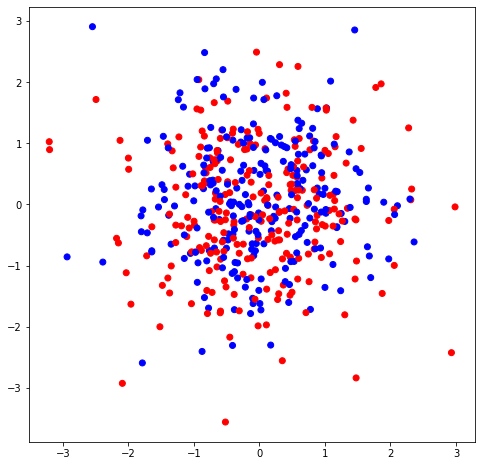

In [2]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=500, n_features=200
                                       , n_informative=20,
                                       n_redundant=0, n_classes=2, random_state=1)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

In [3]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (350, 200)
Размер массива признаков тестовой выборки (150, 200)
Размер массива ответов для обучающей выборки (350,)
Размер массива ответов для тестовой выборки (150,)


In [4]:
def calc_std_feat(x):
    res = (x - x.mean()) / x.std()
    return res

In [5]:
X_train_st = X_train.copy()
X_test_st = X_test.copy()
X_train_st[2, :] = calc_std_feat(X_train[2, :])
X_test_st[2, :] = calc_std_feat(X_test[2, :])

In [6]:
X_train_st

array([[ 0.0270273 , -1.22005222,  1.20779365, ...,  0.90885661,
        -0.26737799, -0.54745145],
       [ 0.02355716, -1.72688218,  1.79773277, ..., -0.24687583,
         1.45158678,  0.64220362],
       [ 0.75090109, -0.19550848,  1.73052237, ...,  1.03484994,
        -0.57579567, -0.32421266],
       ...,
       [ 0.29562503, -1.46234993, -0.462948  , ...,  1.62367119,
        -1.15226632, -2.17740333],
       [-0.6737456 ,  0.08605881, -0.139226  , ...,  0.89760968,
        -0.46749842,  1.03705307],
       [ 0.4848866 ,  0.65090748, -0.84869952, ..., -0.41209777,
         1.74545488,  0.23565927]])

In [7]:
X_train_tr = X_train_st.transpose()
y_train_tr = y_train.reshape(1, y_train.shape[0])
X_test_tr = X_test_st.transpose()
y_test_tr = y_test.reshape(1, y_test.shape[0])

In [8]:
def calc_logloss(y, y_pred):
    for i in range(y_pred.shape[0]):
        if y_pred[i] != 0 or y_pred[i] != 1:
            err = - np.mean(y * np.log(y_pred + 0.0001) + (1.0 - y) * np.log(1.0 - y_pred + 0.0001))
        else:
            err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [10]:
def eval_model(X, y, iterations, alpha):
    np.random.seed(42)
    error = []
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T))
        error.append(err)
    if i % (iterations / 10) == 0:
        print(i, W, err)
    return W, error

In [11]:
def calc_pred(w, X):
    
    m = X.shape[1]
    
    y_pred = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X))
    
#     За порог отнесения к тому или иному классу примем вероятность 0.5
    for i in range(A.shape[1]):
        if (A[:,i] > 0.5): 
            y_pred[:, i] = 1
        elif (A[:,i] <= 0.5):
            y_pred[:, i] = 0
    
    return y_pred

In [12]:
# иницилизируем начальный вектор весов
w0 = np.zeros((X_train_tr.shape[0], 1))

W, error = eval_model(X_train_tr, y_train, iterations=1000, alpha=0.01)

y_predicted_test = calc_pred(W, X_test_tr)
y_predicted_train = calc_pred(W, X_train_tr)

#print(f"Итоговый вектор весов w: {w}")

1000 [ 0.63190606  0.21713767  0.48112323  1.1493763  -0.24635573 -0.18595328
  1.06599535  0.71930746 -0.38954971  0.40179146 -0.03666916  1.06441726
 -0.50196886 -1.91976513 -1.17240491 -0.39044084 -0.50824779 -0.71352539
 -0.53827443 -1.22905337  1.43827671  0.33574653 -0.06605192 -0.16817791
 -0.47637852  0.19419019 -1.08644778 -0.14238996 -0.40004521 -0.15233438
 -0.49251459  1.39845497  0.02531576 -1.04568805  0.43500648 -1.11655862
  0.14465155 -0.9575422  -0.79445152  0.10393974  0.73494804  0.31399076
  0.27616989 -0.41042938 -1.3078827  -0.55608537 -0.20404456  0.94501109
  0.53101005 -1.29738716  0.54258461 -0.26526457 -0.56365599  0.29776308
  1.08851321  1.13127089 -0.25499329 -0.21431837  0.60899029  0.48109788
 -0.15920107 -0.03427596 -0.9707716  -0.88865044  0.68622654  0.82850369
  0.13138207  0.88172747  0.57855579 -0.96725562  0.20329605  1.28630322
  0.2014863   1.34778941 -1.78131118  0.7420888   0.22467191  0.37069039
  0.52434225 -1.60156891  0.55498672  0.275968

In [13]:
error

[3.8787511381721367,
 3.8704378865891598,
 3.8621100445192367,
 3.853767778207293,
 3.8454112876556557,
 3.8370408109341967,
 3.8286566306443457,
 3.8202590821304914,
 3.811848562802757,
 3.8034255417564258,
 3.7949905687698844,
 3.7865442817403157,
 3.77808741168641,
 3.769620784606799,
 3.7611453197193527,
 3.752662023897874,
 3.744171982436562,
 3.7356763465701652,
 3.727176318430151,
 3.7186731342894173,
 3.710168047033391,
 3.7016623087879035,
 3.693157154545765,
 3.684653787491091,
 3.6761533665397486,
 3.667656996428481,
 3.659165720511518,
 3.6506805162747398,
 3.6422022934641,
 3.6337318946416852,
 3.625270097930483,
 3.61681762167258,
 3.608375130702382,
 3.599943243915172,
 3.591522542789485,
 3.5831135804990866,
 3.574716891227266,
 3.566332999283363,
 3.5579624276214705,
 3.549605705380485,
 3.5412633741121926,
 3.5329359924296764,
 3.524624138898468,
 3.516328413090293,
 3.508049434820608,
 3.4997878416808725,
 3.4915442850493874,
 3.4833194248112926,
 3.475113923041569,


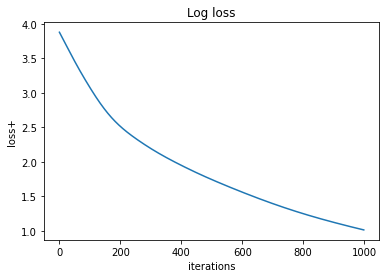

In [14]:
plt.title('Log loss')
plt.xlabel('iterations')
plt.ylabel('loss+')
plt.plot(range(len(error)), error[:])

In [15]:
def accuracy(y_test, y_pred):
    count = 0
    q0 = 0
    for i in range(y_test.shape[1]):
        if y_test[:,i] == 1:
            q0 += 1
        if y_test[:,i] - y_pred[:,i] == 0:
            count += 1
    return f"accuracy: {count/y_test.shape[1]}, q0 коэффициент {q0/y_test.shape[1]}"

In [16]:
accuracy(y_test_tr, y_predicted_test)

'accuracy: 0.74, q0 коэффициент 0.47333333333333333'

In [17]:
def matrix_mis(y_test, y_pred):
    tp = 0
    fn = 0
    fp = 0
    tn = 0
    for i in range(y_test.shape[1]):
        if y_test[:,i]== 1 and y_pred[:,i]== 1:
            tp += 1
        elif y_test[:,i]== 0 and y_pred[:,i]== 0:
            tn += 1
        elif y_test[:,i] - y_pred[:,i] == 1:
            fn += 1
        elif y_test[:,i] - y_pred[:,i] == -1:
            fp += 1
    print(tp,tn,fn,fp)
    TP = tp/y_test.shape[1]
    FN = fn/y_test.shape[1]
    FP = fp/y_test.shape[1]
    TN = tn/y_test.shape[1]
    print(f"TP: {tp/y_test.shape[1]}, FN {fn/y_test.shape[1]}, FP: {fp/y_test.shape[1]}, TN {tn/y_test.shape[1]}")
    return TP, FN, FP, TN

In [18]:
TP, FN, FP, TN = matrix_mis(y_test_tr, y_predicted_test)

56 55 15 24
TP: 0.37333333333333335, FN 0.1, FP: 0.16, TN 0.36666666666666664


In [19]:
def precision_score(tp, fp):
    precision = tp/ (tp + fp)
    return precision

In [20]:
def recall_score(tp, fn):
    recall = tp/ (tp + fn)
    return recall

In [21]:
precision_score(TP, FP)

0.7000000000000001

In [22]:
precision = precision_score(TP, FP)

In [23]:
recall_score(TP, FN)

0.7887323943661971

In [24]:
recall = recall_score(TP, FN)

In [25]:
def f_score(precision, recall):
    f_score = 2*(precision*recall)/(precision+recall)
    return f_score

In [26]:
f_score(precision, recall)

0.7417218543046358

Ответ на вопрос - могла бы переобучиться модель и почему? в самом вопросе содержится подсказка, что могла, хотя на моих данных не похоже на то. Данные получились сбалансированные, с высокой представленностью ответов 1 категории в выборке. Возможно, переобученность могла бы возникнуть, если бы я использовала и регуляризации, и не логарифмическую функцию, а квадратичную или экспонинциальную функцию для подсчета log loss? 